# Load, clean, and display data

In [226]:
# !pip install arch             # uncomment for installing the arch package
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [227]:
# Read data file

df = pd.read_excel('/Users/jinhyun/Documents/GitHub/Python/assignment/assignmentsmodelvalidatortradingriskmodelsating/1. IndexData.xls') # imports the data
display(df)

,Date,DAX,SMI
0,2007-03-30,6917.03,8976.99
1,2007-04-02,6937.17,8956.31
2,2007-04-03,7045.56,9053.95
3,2007-04-04,7073.91,9057.62
4,2007-04-05,7099.91,9099.08
...,...,...,...
780,2010-03-26,6120.05,6838.95
781,2010-03-29,6156.85,6850.58
782,2010-03-30,6142.45,6871.42
783,2010-03-31,6153.55,6873.37


Now we transform the data 

In [228]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # transform date strings to datetime 
df = df.set_index(['Date']) # set index of DataFrame to the date column

In [229]:
df['R_DAX'] = np.log(df[['DAX']]) - np.log(df[['DAX']]).shift(1) # calculate DAX returns
df['R_SMI'] = np.log(df[['SMI']]) - np.log(df[['SMI']]).shift(1) # calculate SMI returns
df = df.dropna() # drop N/A entries
R_DAX = 100 * (df['R_DAX'])['2007-03-30':] # transform returns to percentages (recommended for GARCH package) and remove first row from returns 
R_SMI = 100 * (df['R_SMI'])['2007-03-30':] 

df['DAX_eur'] =  df[['DAX']]*500 # find the value of indices
df['SMI_eur'] =  df[['SMI']]*450 

display(df)


,DAX,SMI,R_DAX,R_SMI,DAX_eur,SMI_eur
Date,,,,,,
2007-04-02,6937.17,8956.31,0.002907,-0.002306,3468585.0,4030339.5
2007-04-03,7045.56,9053.95,0.015504,0.010843,3522780.0,4074277.5
2007-04-04,7073.91,9057.62,0.004016,0.000405,3536955.0,4075929.0
2007-04-05,7099.91,9099.08,0.003669,0.004567,3549955.0,4094586.0
2007-04-06,7099.91,9099.08,0.000000,0.000000,3549955.0,4094586.0
...,...,...,...,...,...,...
2010-03-26,6120.05,6838.95,-0.002106,-0.008042,3060025.0,3077527.5
2010-03-29,6156.85,6850.58,0.005995,0.001699,3078425.0,3082761.0
2010-03-30,6142.45,6871.42,-0.002342,0.003037,3071225.0,3092139.0


Display a line graph of the returns,

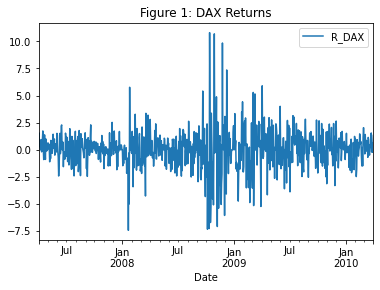

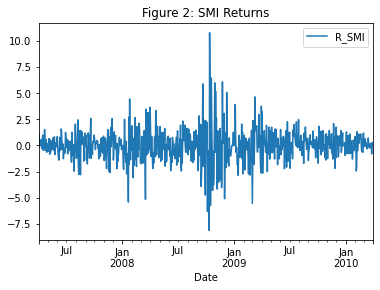

Skewness
DAX : 0.2580297683212391 / SMI: 0.18726592410554294
Kurtosis
DAX : 6.460467916791624 / SMI: 6.327211792289831


In [230]:
# line graph of the returns
R_DAX.plot()
plt.title('Figure 1: DAX Returns')
plt.legend(['R_DAX'])
plt.show()

R_SMI.plot()
plt.title('Figure 2: SMI Returns')
plt.legend(['R_SMI'])
plt.show()

# Calculate the skewness and kurtosis of the returns.

# returns the skewness of a series
print("Skewness")
print('DAX :', R_DAX .skew(),'/ SMI:',R_SMI.skew())

# returns the excess kurtosis of a series
print("Kurtosis")
print('DAX :',R_DAX.kurtosis() ,'/ SMI:',R_SMI.kurtosis()) 


a)	Estimate the 1-day 99% VaR of both portfolios (individually) on the situation date 1 April 2010 using the Normal VaR approach. 

In [231]:
# the pth quantile of the normal distribution 
p=0.01
pquantile_norm = stats.norm.ppf(p)

# Obtain the 'VaR forecasts' and compute the 'percentage of exceedences'. 

c_DAX = np.std(R_DAX) # a constantseries / cons_std = R*0 + c
c_SMI = np.std(R_SMI) 
VaR_forecast_norm_DAX = -c_DAX *stats.norm.ppf(p)
VaR_forecast_norm_SMI = -c_SMI *stats.norm.ppf(p)
print('DAX, VaR_forecast (Normal distribution):', VaR_forecast_norm_DAX)
print('SMI, VaR_forecast (Normal distribution):', VaR_forecast_norm_SMI)

hit_series_norm_DAX = np.where(R_DAX< -VaR_forecast_norm_DAX, 1, 0) # Create a hit series. 1: if R < -VaR_forecast
hit_series_norm_SMI = np.where(R_SMI< -VaR_forecast_norm_SMI, 1, 0)

per_exceed_norm_DAX = sum(hit_series_norm_DAX)/len(hit_series_norm_DAX)   # Calculate the percentage of exceedence.
per_exceed_norm_SMI = sum(hit_series_norm_SMI)/len(hit_series_norm_SMI)
print('DAX, Percentage of exceedence (Normal distribution):', str(per_exceed_norm_DAX*100) +'%')
print('SMI, Percentage of exceedence (Normal distribution):', str(per_exceed_norm_SMI*100) +'%')


DAX, VaR_forecast (Normal distribution): 4.154196716704126
SMI, VaR_forecast (Normal distribution): 3.5801197452025413
DAX, Percentage of exceedence (Normal distribution): 2.5510204081632653%
SMI, Percentage of exceedence (Normal distribution): 1.913265306122449%


b)	Explain if the assumption of normally distributed returns is valid. 

In [232]:
print('DAX :', stats.jarque_bera(R_DAX))
print('SMI :', stats.jarque_bera(R_SMI))

DAX : Jarque_beraResult(statistic=1351.5881129202207, pvalue=0.0)
SMI : Jarque_beraResult(statistic=1292.5938610563617, pvalue=0.0)


Jarque-Bera test is designed to test the normality (goodness of fit test). The test statistic for JB test with p = 99.5% is 10.597.
The actual result of the DAX return is larger than JB test statistic. (1345.2635 > 10.597)
The actual result of the SMI return is larger than JB test statistic. (1286.1795 > 10.597)
The p values from two types of returns are also significant (p < 0.0)
Therefore we can conclude that the assumption of normally distributed reuturn is not valid


c)	Estimate the 1-day 99% VaR for both portfolios (individually) on the situation date 1 April 2010 using the Historical Simulation approach. 

In [233]:
historic_var_DAX = np.percentile(R_DAX, 1, interpolation='lower')
historic_var_SMI = np.percentile(R_SMI, 1, interpolation='lower')

print(f'The historical DAX 1% VaR is {historic_var_DAX}')
print(f'The historical SMI 1% VaR is {historic_var_SMI}')



The historical DAX 1% VaR is -5.395137508116576
The historical SMI 1% VaR is -5.096579186276351


## 2 

a)	Estimate the 1-day 99% VaR of the consolidated portfolio for the situation date 1 April 2010 using the Normal Variance-Covariance VaR approach. 

In [234]:
# Declare Empty Lists
Mean = []
STD = []
MAX = []
Min = []
abs_var = []
re_var = []

#Calculate DEAR
ticker1 = ['DAX_eur', 'SMI_eur']
ticker2 = ['R_DAX', 'R_SMI']
value = df[['DAX_eur', 'SMI_eur']].iloc[-1]

for i in range(2):
    v = df[ticker2[i]].std()              # Standard Error
    mean = df[ticker2[i]].mean()          # Mean 
    maximum = df[ticker2[i]].max()        # Maximum
    minimum = df[ticker2[i]].min()        # Minimum
    
    # Calculate 99% Absolute VaR
    var_99_ab = (abs(-2.33)*v - mean) * value[ticker1[i]]

    # Calculate 99% Relative VaR
    var_99_re = (abs(-2.33)*v) * value[ticker1[i]]      
    
    # Append those values in lists
    Mean.append(mean)
    STD.append(v)
    MAX.append(maximum)
    Min.append(minimum)
    abs_var.append(var_99_ab)
    re_var.append(var_99_re)

Construct new Table

In [235]:
dear = pd.DataFrame({'Mean': Mean, 'STD': STD, 'Maximum': MAX, 'Minimum': Min, '99%_abs_VaR': abs_var, '99%_rel_VaR': re_var}, index = ['R_DAX','R_SMI'])
display(dear)

,Mean,STD,Maximum,Minimum,99%_abs_VaR,99%_rel_VaR
R_DAX,-0.000132,0.017869,0.107975,-0.074335,130217.317523,129804.855526
R_SMI,-0.000338,0.015399,0.107876,-0.081081,112276.255907,111229.406830


Correlation Coefficient

In [236]:
rho = df[['R_DAX','R_SMI']].corr() # dfis the transposed one of return data
display(rho)

#Instead of price data, we apply return data to get the correlation coefficient among stocks. 
# By doing so, we would avoid Spurious Regression and compute correct coefficient.


,R_DAX,R_SMI
R_DAX,1.000000,0.818536
R_SMI,0.818536,1.000000


Portfolio VaR


Step 1. Concatenate Tables

In [237]:
dear = dear.drop(columns = ['Mean', 'STD', 'Maximum', 'Minimum'])

# concatenate dear and rho
portfolio = pd.concat([dear, rho,], axis = 1) 
portfolio[['99%_abs_VaR', '99%_rel_VaR']] = portfolio[['99%_abs_VaR', '99%_rel_VaR']]

In [238]:
portfolio

,99%_abs_VaR,99%_rel_VaR,R_DAX,R_SMI
R_DAX,130217.317523,129804.855526,1.000000,0.818536
R_SMI,112276.255907,111229.406830,0.818536,1.000000


Calculate VaR

In [ ]:
# the proportion of VaR of stocks itself in portfolio
part1 = sum(portfolio['99%_abs_VaR']**2)


# VaR with the adjustment of correlation coefficient among different stocks


